# **Automatic Differentiation Engine**

*Ayush Singh ,B.Tech Mathematics and Computing @ IIT Mandi*
<u>ayush.rocketeer@gmail.com</u>

In [284]:
!pip install -r requirements.txt
# you can run benchmarks via micrograd in the benchmark notebook

In [285]:
import math
# used for exponential and tanh operations
from graphviz import Digraph
# used for visualizing the computational graph


---
## **Computational Graph**

# Primitive Operations in Our Computational Graph

Our computational graph supports the following **primitive operations**, which can be used as building blocks in a network for computation:

- **Addition** (`+`)
- **Subtraction** (`-`)
- **Multiplication** (`*`)
- **Division** (`/`)
- **Exponentiation** (to any positive base)
- **Hyperbolic tangent** (`tanh`)


In [286]:
class ValueNode():
    def __init__(self, value,  prev = (), op = '', label = ''):
        self.value = value
        self.prev = set(prev)               # saving parents
        self.op = op                        # visualization help
        self.label = label                  # for graphviz visualization
        self.grad = 0.0                     # numeric gradient that back propagates
        self._backward = lambda : None      # this backward defines the local derivative function

    def __repr__(self):                     # represent function to handle debugging, etc
        return f'Value: {self.value}'

    def __add__(self, other):               # operator overloading to allow shorthands and numpy style operations
        other = other if isinstance(other, ValueNode) else ValueNode(other)
        out =  ValueNode(self.value+other.value, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad     # see note below to understand how local derivative and upstream derivative is used to compute gradient
            other.grad += out.grad * 1.0
        out._backward = _backward           # setting backward for child
        return out

    def __radd__(self, other):     # reverse add
        return self + other        # this handles the case of returning a node if self itself is not a node, allows us to do 2+a

    def __sub__(self, other):
        other = other if isinstance(other, ValueNode) else ValueNode(other)
        out = ValueNode(self.value-other.value, (self, other), '-')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += out.grad * (-1.0)
        out._backward = _backward
        return out

    def __rsub__(self, other):
        other = other if isinstance(other, ValueNode) else ValueNode(other)
        return other - self


    def __mul__(self, other):
        other = other if isinstance(other, ValueNode) else ValueNode(other)
        out = ValueNode(self.value*other.value, (self, other), '*')
        def _backward():
            self.grad += out.grad * other.value
            other.grad += self.value * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, ValueNode) else ValueNode(other)
        out = ValueNode(self.value / other.value, (self, other), '/')
        def _backward():
            self.grad += out.grad * (1 / other.value)
            other.grad += out.grad * (-self.value / other.value**2)
        out._backward = _backward
        return out

    def __rtruediv__(self, other):
        other = other if isinstance(other, ValueNode) else ValueNode(other)
        return other / self


    def tanh(self):
        out = ValueNode(math.tanh(self.value), (self,), 'tanh')
        def _backward():
            self.grad += out.grad * (1 - (math.tanh(self.value)**2))
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"         # limited non interger, non float powers
        out = ValueNode(self.value**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.value ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __neg__(self):                          # utility allowing us to do -a instead of -1*a
        return self * -1

    def relu(self):                            # Rectified Linear Unit activation function
        out = ValueNode(0 if self.value < 0 else self.value, (self,), 'ReLU')
        def _backward():
            self.grad += (out.value > 0) * out.grad
        out._backward = _backward
        return out


    def backward(self):                       # Universal backward, that does backward pass on a graph
        topo = []
        visited = set()
        def build_topo(v):                    # topological sort used to compute all child gradients before computing parent gradient
          if v not in visited:                # topological sort and its need (total derivative rule) is explained below
            visited.add(v)
            for child in v.prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0                      # initialize ∂L/∂L = 1 where L is the final (Loss) node
        for node in reversed(topo):
          node._backward()


# **Mini Autograd Engine: Gradient Flow (General)**

Let `x, y` be inputs, `f` an intermediate node, and `Loss` the final output. Each node stores `.grad` which accumulates:

$$
x.\text{grad} = \frac{\partial \text{Loss}}{\partial x}, \quad
y.\text{grad} = \frac{\partial \text{Loss}}{\partial y}
$$

---

## Chain Rule at Each Node

Each node only knows **how it depends on its immediate inputs**. Let `out` be the output of an operation `f(x, y)`. Then the local `_backward()` computes:

$$
x.\text{grad} \space \text{+=} \space \frac{\partial f}{\partial x} \cdot \text{out.grad}
$$

$$
y.\text{grad} \space \text{+=} \space \frac{\partial f}{\partial y} \cdot \text{out.grad}
$$

Here:

- `out.grad` = upstream gradient = $\frac{\partial \text{Loss}}{\partial f}$
- `∂f/∂x` and `∂f/∂y` = **local derivatives** of this operation

---

### Notes

- Each `_backward()` is **local**, only using its inputs and `out.grad`.
- `.grad` values **accumulate contributions** if multiple downstream paths reach the same node.
- The final gradient w.r.t any input emerges from repeated application of this rule **through the whole graph**.
- += is used instead of = to allow for multiple influence paths along variables and not overwrite such updates

---

# **Topological Sort for Backpropagation**

When implementing **backpropagation** in a computational graph, the key idea is that the output of some nodes depends on other nodes. To correctly propagate gradients, we must process nodes in an order that respects these dependencies — i.e., **topological order**.

---

## 1. Total Derivative Rule

If a function $f$ depends on intermediate variables $$u_1, u_2, ..., u_n$$, which in turn depend on $$x$$, the derivative of $$f$$ with respect to $$x$$ is:

$$
\frac{\partial f}{\partial x} = \sum_i \frac{\partial f}{\partial u_i} \frac{\partial u_i}{\partial x}
$$

This is the **chain rule in its general form** — sometimes called the **total derivative rule**.

**Example:**

If $$f = g(u, v)$$ with $$u = u(x), v = v(x)$$:

$$
\frac{df}{dx} = \frac{\partial f}{\partial u} \frac{du}{dx} + \frac{\partial f}{\partial v} \frac{dv}{dx}
$$

---

## 2. Backpropagation via Topological Sort

Consider a **computational graph**:

- Nodes = operations (e.g., addition, multiplication, activation)
- Edges = dependencies (inputs → outputs)

**Steps:**

1. **Forward pass:** Compute all node values in any **topological order** (inputs first, outputs last).
2. **Initialize gradients:** Set gradient of final output node $$f$$ w.r.t itself as 1:

$$
\frac{\partial f}{\partial f} = 1
$$

3. **Backward pass:** Traverse nodes in **reverse topological order**, applying the total derivative rule:

$$
\text{For node } x: \quad \frac{\partial f}{\partial x} = \sum_{\text{children } u} \frac{\partial f}{\partial u} \frac{\partial u}{\partial x}
$$

- Each node accumulates contributions from all nodes that directly depend on it.
- This is exactly the general chain rule in action.

---

### Key Insights

1. **Topological order ensures no node is processed before all its dependencies are ready.**
2. **Reverse topological traversal naturally implements backpropagation.**
3. **The sum in the total derivative rule is exactly how contributions from multiple paths are handled.**
4. This framework generalizes to any **DAG-based computation**, not just neural networks.

---

<div class="alert alert-block alert-success">
<b>Takeaway : backpropagation is just the chain rule applied efficiently over a DAG</b>, and topological sort guarantees we never try to compute a gradient before its dependencies are known.
</div>




## **Graph Visualisation**

In [287]:
# Adapted from Andrej Karpathy's GitHub Notes to visualise the computational graph via graphviz API
# source https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_first_half_roughly.ipynb

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | value %.4f | grad %.4f }" % (n.label, n.value, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot

## **Neurons and the MLP**
"*The Solution to Everything*" - People in the 1950s

In [288]:
class Module:                   # abstract class from which Neuron, Layer and MLP inherit
    def zero_grad(self):        # for training, to prevent accumulation
        for param in self.parameters():
            param.grad = 0

    def parameters(self):      # list out all the weights in a neuron, layer or MLP
        return []

In [289]:
class Neuron(Module):
    def __init__(self, n_inputs, activate = True):                                          # initialize a n->1 neuron
        self.w = [ValueNode(np.random.uniform(-1,1)) for _ in range(n_inputs)]
        self.b = ValueNode(np.random.uniform(-1,1))
        self.activate = activate                                                            # this can have linear output as well, but if nonlinear by default

    def __call__(self, x):
        z = sum((w*x for w,x in zip(self.w, x)), self.b)                                    # computing output
        return z.relu() if self.activate else z                                             # reLU default activation function

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):                                                                    # representation of the neuron
        return f"{'ReLU' if self.activate else 'Linear'}Neuron({len(self.w)})"


In [290]:
class Layer(Module):
    def __init__(self, n_inputs, n_outputs, **kwargs):                                    # **kwargs to specify if linearity is needed
        self.neurons = [Neuron(n_inputs, **kwargs) for _ in range(n_outputs)]             # n_outputs neurons each with n_inputs inputs
    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())                                           # appending in order the parameters of each neuron
        return params
    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

In [291]:
class MLP(Module):
    def __init__(self, n_inputs, n_outputs):                                                            # n_inputs here is a list of layer widths
        neuron_list = [n_inputs] + n_outputs
        self.layers = [Layer(neuron_list[i], neuron_list[i+1], activate=i!=len(n_outputs)-1) for i in range(len(n_outputs))]   # creating a list of layers with linear output for last layer

    def __call__(self, x):
        for layer in self.layers:                                                                       # evaluation the output of the MLP
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

    def train(self, loss, epochs, schedule = True, batch_size = None):                                  # Training with Minibatch GD capabilities, loss is loss function
        for epoch in range(epochs):
            total_loss, accuracy = loss(batch_size)                                                     # forward pass
            self.zero_grad()                                                                            # zeroing out gradients
            total_loss.backward()
            learning_rate = (1 - 0.9*epoch/100) if schedule else 0.03                                   # learning schedule to decay learning rate
            for parameter in self.parameters():
                parameter.value -= learning_rate * parameter.grad                                       # parameter update
            print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss.value:.5f}, Accuracy: {accuracy*100:.2f}%')

---
# **Examples and Demonstration**

### Graph Visualization

In [292]:
"""
a = ValueNode(1)
b = ValueNode(2)
c = a*b
d = a/c
e = a+b+c/d
draw_dot(e)
"""
# Commented to export to PDF

'\na = ValueNode(1)\nb = ValueNode(2)\nc = a*b\nd = a/c\ne = a+b+c/d\ndraw_dot(e)\n'

### Gradient Calculation

In [293]:
"""
e.backward()
draw_dot(e)
"""
# Commented to export to PDF

'\ne.backward()\ndraw_dot(e)\n'

### Neuron, Layer and MLP Demonstration

In [294]:
x = [1,1]
neuron = Neuron(2)            # neuron with 2 inputs and an output
layer = Layer(2, 2)           # layer with two such neurones defined above
perceptron = MLP(2,[4,4,1],)  # perceptron with 2 inputs, 2 hidden layers of 4 neurons and one final output

print(neuron(x), layer(x), perceptron(x))

Value: 0.5504097989358798 [Value: 0.5025686837698333, Value: 0] Value: 0.5417098819503215


In [295]:
print([param.grad for param in layer.parameters()])      # viewing grads

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


#### Make Moons Example

In [296]:
mlp = MLP(2,[16,16,1])                # Creating a Neural Net with 2,16,16,1 neurons (4 layers)

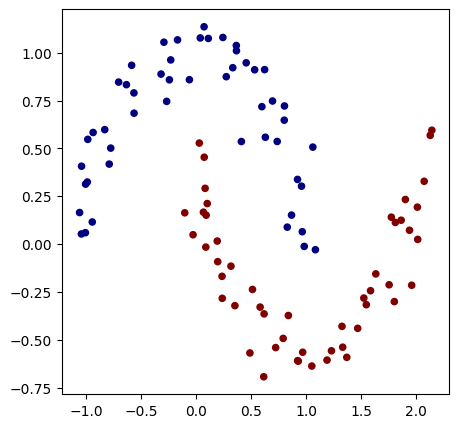

In [297]:
import numpy as np
import matplotlib.pyplot as plt

# A synthetic moons dataset is created to match Karpathy's for benchmarking

from sklearn.datasets import make_moons        # using scikit-learn's API to make the dataset
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1                                 # make y be -1 or 1

# visualize in 2D using matplotlib
plt.figure(figsize=(5,5));
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet');

In [298]:
# loss function [reference from Andrej Karpathy's library to benchmark https://github.com/karpathy/micrograd/blob/master/demo.ipynb]
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(ValueNode, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(mlp, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    total_loss = sum(losses) * (1.0 / len(losses))

    # We dropped regularisation used by Karpathy to evaluate whether decision boundary overfits further in this case

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.value > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value: 1.0694030252877538 0.5


In [299]:
mlp.train(loss,50)
# Train using loss function defined above, full gradient descent, a learning schedule, and 50 epochs


Epoch 1/50, Loss: 1.06940, Accuracy: 50.00%
Epoch 2/50, Loss: 5.30569, Accuracy: 50.00%
Epoch 3/50, Loss: 1.29020, Accuracy: 50.00%
Epoch 4/50, Loss: 0.53764, Accuracy: 78.00%
Epoch 5/50, Loss: 0.49592, Accuracy: 83.00%
Epoch 6/50, Loss: 0.35674, Accuracy: 84.00%
Epoch 7/50, Loss: 0.27127, Accuracy: 86.00%
Epoch 8/50, Loss: 0.23547, Accuracy: 88.00%
Epoch 9/50, Loss: 0.22299, Accuracy: 90.00%
Epoch 10/50, Loss: 0.25094, Accuracy: 87.00%
Epoch 11/50, Loss: 0.18056, Accuracy: 91.00%
Epoch 12/50, Loss: 0.16738, Accuracy: 93.00%
Epoch 13/50, Loss: 0.21138, Accuracy: 91.00%
Epoch 14/50, Loss: 0.20003, Accuracy: 92.00%
Epoch 15/50, Loss: 0.13473, Accuracy: 93.00%
Epoch 16/50, Loss: 0.10388, Accuracy: 94.00%
Epoch 17/50, Loss: 0.09469, Accuracy: 98.00%
Epoch 18/50, Loss: 0.12102, Accuracy: 96.00%
Epoch 19/50, Loss: 0.08464, Accuracy: 98.00%
Epoch 20/50, Loss: 0.08257, Accuracy: 97.00%
Epoch 21/50, Loss: 0.13869, Accuracy: 97.00%
Epoch 22/50, Loss: 0.41195, Accuracy: 88.00%
Epoch 23/50, Loss: 

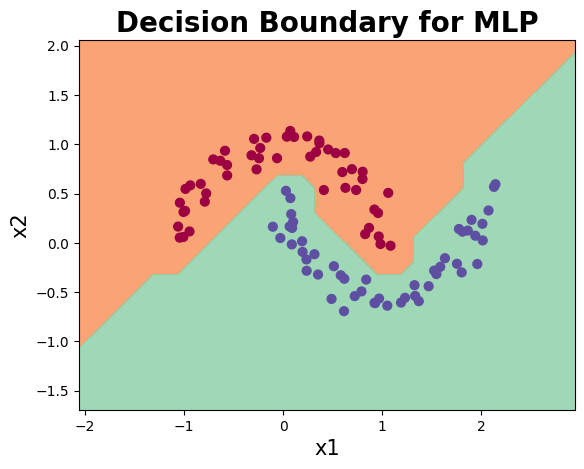

In [300]:
# visualise decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(ValueNode, xrow)) for xrow in Xmesh]
scores = list(map(mlp, inputs))
Z = np.array([s.value > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure();
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8);
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral);
plt.xlim(xx.min(), xx.max());
plt.ylim(yy.min(), yy.max());

plt.title('Decision Boundary for MLP', fontsize=20, fontweight='bold');
plt.xlabel('x1', fontsize=15);
plt.ylabel('x2', fontsize=15);


<div class="alert alert-block alert-success">
<b>Takeaway : Even without regularisation, this custom model performs nearly identically to micrograd/b> (convergence takes longer primarily due to lack of regularization). Benchmarking with Karpathy's Code and PyTorch and be checked out in the Benchmarking notebook.
</div>